# SciBERT Multi-label Classification (Micro F1)

This notebook demonstrates the process of training and evaluating a multi-label classification model using SciBERT, focusing on micro F1 metrics. Each step is explained in detail.

## Import Libraries

Import all necessary libraries for data handling, model training, and evaluation.

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, AutoConfig, EarlyStoppingCallback
from datasets import Dataset, DatasetDict
import evaluate
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix


import pandas as pd
import torch

2025-07-08 19:34:18.572723: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-08 19:34:18.915703: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-07-08 19:34:18.915735: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-07-08 19:34:18.949746: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-07-08 19:34:19.017610: I tensorflow/core/platform/cpu_feature_guar

## Device Setup

Check if a GPU is available and set the device for PyTorch accordingly.

In [ ]:
if torch.cuda.is_available():

    device_id = 0  # Example: select the second GPU

    torch.cuda.set_device(device_id)

    print(f"Using GPU: {torch.cuda.current_device()}") # Display the selected device ID

else:

    device = torch.device("cpu")

    print(f"Using CPU: {device}")

Using GPU: 0


In [ ]:
if torch.cuda.is_available():
    current_device = torch.cuda.current_device()
    print(f"Current GPU device ID: {current_device}")

Current GPU device ID: 0


## Load and Prepare Data

Load the ACT2 dataset, select relevant columns, and rename the label column for clarity.

In [ ]:
df_act2_full = pd.read_csv('ACT2_dataset.tsv', sep='\t', usecols=['cited_title','cited_abstract','citation_context', 'unique_id','citation_class_label'])

#Rename column "citation_class_label" to "labels"
df_act2_full.rename(columns={'citation_class_label': 'labels'}, inplace=True)

## Data Cleaning

Fill missing values in the title and abstract columns with empty strings.

In [ ]:
df_act2_full['cited_title'] = df_act2_full['cited_title'].fillna('')
df_act2_full['cited_abstract'] = df_act2_full['cited_abstract'].fillna('')

## Feature Engineering

Concatenate the title, abstract, and citation context into a single input string for the model.

In [ ]:
df_act2_full['input_model'] = df_act2_full['cited_title'] + " " \
                            + df_act2_full['cited_abstract'] +  " [ES_SEP] " \
                            + df_act2_full['citation_context']

## Split Data

Split the dataset into test and train sets. The first 1000 samples are used for testing, and the rest for training.

In [ ]:
df_act2_test = df_act2_full.head(1000)
df_act2_train = df_act2_full.tail(len(df_act2_full) - 1000)

In [ ]:
df_act2_train

,unique_id,cited_title,cited_abstract,citation_context,labels,input_model
1000,CC1001,Web search personalization with ontological us...,Every user has a distinct background and a spe...,They usually generate user models that describ...,5,Web search personalization with ontological us...
1001,CC1002,Exploring Scholarly Data with Rexplore,Despite the large number and variety of tools ...,The Computer Science Ontology (CSO) [3] is a l...,0,Exploring Scholarly Data with Rexplore Despite...
1002,CC1003,Klink-2: Integrating Multiple Web Sources to G...,The amount of scholarly data available on the ...,"In order to do so, we characterized all SN pub...",0,Klink-2: Integrating Multiple Web Sources to G...
1003,CC1004,Forecasting the Spreading of Technologies in R...,"Technologies such as algorithms, applications ...","This API supports a number of applications, in...",0,Forecasting the Spreading of Technologies in R...
1004,CC1005,Supporting Springer Nature Editors by means of...,The Open University and Springer Nature have b...,"1) It represents journals, books, and conferen...",5,Supporting Springer Nature Editors by means of...
...,...,...,...,...,...,...
3995,CC3996,Modelling channel evolution and floodplain mor...,,In order to conclude whether identified fluvia...,0,Modelling channel evolution and floodplain mor...
3996,CC3997,Atlas of the Danube River Vienna A history of ...,,It can be considered as the first map of the V...,5,Atlas of the Danube River Vienna A history of ...
3997,CC3998,Alte Grenzen im Wiener Raum,,"Borders of land properties, hunting grounds or...",0,Alte Grenzen im Wiener Raum [ES_SEP] Borders ...
3998,CC3999,Avulsive channel systems: characteristics and ...,,"Due to the high bed shear stress, new channels...",0,Avulsive channel systems: characteristics and ...


## Train/Validation Split

Further split the training data into train and validation sets, stratified by label.

In [ ]:
train_df, val_df = train_test_split(
    df_act2_train,
    test_size=0.2,
    stratify=df_act2_train['labels'],
    random_state=42  # Setting a random state for reproducibility
)
print(f"Train data size: {len(train_df)}")
print(f"Validation data size: {len(val_df)}")

Train data size: 2400
Validation data size: 600


In [ ]:
train_df

,unique_id,cited_title,cited_abstract,citation_context,labels,input_model
1858,CC1859,"Strategic, structural contingency and institut...",,Our hypotheses were all supported; in particul...,5,"Strategic, structural contingency and institut..."
2921,CC2922,The semantics of number in the Arabic noun phrase,Previous models of searching behavior have tak...,Most roots in Arabic are made up of three cons...,0,The semantics of number in the Arabic noun phr...
1470,CC1471,The neurology of syntax: Language use without ...,A new view of the functional role of the left ...,"English passives are ""harder"" with regard to a...",0,The neurology of syntax: Language use without ...
3756,CC3757,COMPETITIVE GROUPS AS COGNITIVE COMMUNITIES: T...,,"As such, the concept of network pictures is in...",2,COMPETITIVE GROUPS AS COGNITIVE COMMUNITIES: T...
1855,CC1856,Extending sustainability to suppliers: a syste...,Purpose - To make their supply chains more soc...,Firms that engage in establishing strong relat...,0,Extending sustainability to suppliers: a syste...
...,...,...,...,...,...,...
1615,CC1616,"Self-Organization, Transformity, and Information",Ecosystems and other self-organizing systems d...,To characterize the organization of the steady...,0,"Self-Organization, Transformity, and Informati..."
3581,CC3582,How we decide,Background: The aim of the study was to invest...,"For instance, recent findings dispute the idea...",1,How we decide Background: The aim of the study...
2150,CC2151,Why the global availability of mind wandering ...,"When the mind wanders, conscious thoughts come...",This debate has been most recently summarized ...,1,Why the global availability of mind wandering ...
2702,CC2703,The EuroBioBank Network: 10 years of hands-on ...,The EuroBioBank (EBB) network (www.eurobiobank...,Prospective initiatives with comparable aims a...,0,The EuroBioBank Network: 10 years of hands-on ...


## Convert to HuggingFace Datasets

Convert the pandas DataFrames to HuggingFace Dataset objects for easier handling.

In [ ]:
dataset = DatasetDict({
    'train': Dataset.from_pandas(train_df, preserve_index=False),
    'validation': Dataset.from_pandas(val_df, preserve_index=False),    
    'test': Dataset.from_pandas(df_act2_test, preserve_index=False)
})

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['unique_id', 'cited_title', 'cited_abstract', 'citation_context', 'labels', 'input_model'],
        num_rows: 2400
    })
    validation: Dataset({
        features: ['unique_id', 'cited_title', 'cited_abstract', 'citation_context', 'labels', 'input_model'],
        num_rows: 600
    })
    test: Dataset({
        features: ['unique_id', 'cited_title', 'cited_abstract', 'citation_context', 'labels', 'input_model'],
        num_rows: 1000
    })
})

## Tokenizer Setup

Initialize the SciBERT tokenizer and add custom tokens.

In [ ]:
model_name = "allenai/scibert_scivocab_uncased"
# Initialize the tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [ ]:
tokenizer.add_tokens(["[ES_SEP]", "#CITATION_TAG"])

2

In [ ]:
batch = train_df.iloc[0]
text = batch["input_model"]
tokens = tokenizer.tokenize(text)
print(text)
print(tokens)

Strategic, structural contingency and institutional explanations in the adoption of innovative manufacturing practices  [ES_SEP] Our hypotheses were all supported; in particular our study highlights the importance of institutional pressures (#CITATION_TAG; Ketchen and Hult, 2007; Liu et al., 2010; Sarkis et al., 2011; Bhakoo and Choi, 2013; Kauppi, 2013; Dubey et al. 2014) and top management commitment (Liang et al., 2007; Gattiker and Carter, 2010; Foerstl et al., 2015; Jabbour and Jabbour, 2015) in the management of both suppliers and customers within the context of GSCM.
['strategic', ',', 'structural', 'contingency', 'and', 'institutional', 'explanations', 'in', 'the', 'adoption', 'of', 'innovative', 'manufacturing', 'practices', '[es_sep]', 'our', 'hypotheses', 'were', 'all', 'supported', ';', 'in', 'particular', 'our', 'study', 'highlights', 'the', 'importance', 'of', 'institutional', 'pressures', '(', '#citation_tag', ';', 'ket', '##chen', 'and', 'hu', '##lt', ',', '2007', ';', 

In [ ]:
def tokenize(batch):
    return tokenizer(batch["input_model"], padding="max_length", truncation=True, max_length=512)

In [ ]:
#Tokenize the dataset
tokenized_datasets = dataset.map(tokenize, batched=True)

Map:   0%|          | 0/2400 [00:00<?, ? examples/s]

Map:   0%|          | 0/600 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [ ]:
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['unique_id', 'cited_title', 'cited_abstract', 'citation_context', 'labels', 'input_model', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 2400
    })
    validation: Dataset({
        features: ['unique_id', 'cited_title', 'cited_abstract', 'citation_context', 'labels', 'input_model', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 600
    })
    test: Dataset({
        features: ['unique_id', 'cited_title', 'cited_abstract', 'citation_context', 'labels', 'input_model', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1000
    })
})

## Label Mapping

Define the mapping between label IDs and label names.

In [ ]:
id2label = {
0 : "Background",
1: "Compares_contrasts",
2:"Extension",
3: "Future",
4: "Motivation",
5: "Uses"
}

label2id = {v: k for k, v in id2label.items()}

## Model Setup

Load the SciBERT model for sequence classification and resize the token embeddings to include new tokens.

In [ ]:
num_labels = len(id2label)

# Load the model
config = AutoConfig.from_pretrained(model_name, num_labels=num_labels, id2label=id2label, label2id=label2id)
model = AutoModelForSequenceClassification.from_pretrained(model_name, config=config)

# Consider new vocabulary size
model.resize_token_embeddings(len(tokenizer))

/usr/local/lib/python3.10/dist-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at allenai/scibert_scivocab_uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


Embedding(31092, 768, padding_idx=0)

In [ ]:
model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(31092, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

## Training Arguments

Set up the training arguments, including batch size, learning rate, and logging.

In [ ]:
batch_size = 32
training_dir = "./checkpoints/scibert_training_global_info_micro"

training_args = TrainingArguments(
    output_dir= training_dir,
    overwrite_output_dir=True,
    eval_strategy ="epoch",
    save_strategy="epoch",
    learning_rate =2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=20,
    weight_decay=0.01,
    logging_dir="./logs/global_train_micro",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    logging_strategy="steps", 
    logging_steps=10,
)

In [ ]:
early_stopping = EarlyStoppingCallback(early_stopping_patience=6) 

In [ ]:
#Compute metrics function

def compute_metrics(eval_pred):

    accuracy = evaluate.load("accuracy")
    f1 = evaluate.load("f1")

    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=1)

    acc = accuracy.compute(predictions=predictions, references=labels)["accuracy"]
    f1_score = f1.compute(predictions=predictions, references=labels, average="micro")["f1"]
    return {
        "f1": f1_score,
        "accuracy": acc
    }

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
    callbacks = [early_stopping]
)

/tmp/ipykernel_2894798/2671797402.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
trainer.train()

/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,F1,Accuracy
1,1.059500,1.192590,0.560000,0.560000
2,0.889500,1.222919,0.583333,0.583333
3,0.690300,1.297873,0.573333,0.573333
4,0.626900,1.336880,0.568333,0.568333
5,0.470800,1.395455,0.565000,0.565000
6,0.384000,1.519102,0.571667,0.571667
7,0.307300,1.565326,0.580000,0.580000
8,0.228800,1.693383,0.586667,0.586667
9,0.193900,1.762537,0.581667,0.581667
10,0.142300,1.800612,0.585000,0.585000


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead u

TrainOutput(global_step=266, training_loss=0.3710955894531164, metrics={'train_runtime': 315.8416, 'train_samples_per_second': 151.975, 'train_steps_per_second': 1.203, 'total_flos': 8840848962355200.0, 'train_loss': 0.3710955894531164, 'epoch': 14.0})

In [ ]:
predictions_output = trainer.predict(test_dataset=tokenized_datasets["test"])

/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


## Compute Metrics and Confusion Matrix

Calculate precision, recall, F1-score, and plot the confusion matrix.

In [ ]:
logits = predictions_output.predictions
true_labels = predictions_output.label_ids
pred_labels = np.argmax(logits, axis=-1)


cm = confusion_matrix(true_labels, pred_labels)

precision, recall, f1, _ = precision_recall_fscore_support(
    true_labels,
    pred_labels,
    average=None  # "macro", "micro", or None for per-class
)

# Get micro and macro scores
precision_micro, recall_micro, f1_micro, _ = precision_recall_fscore_support(
    true_labels, pred_labels, average='micro'
)

precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(
    true_labels, pred_labels, average='macro'
)

print(f"Micro Precision: {precision_micro:.4f}, Recall: {recall_micro:.4f}, F1: {f1_micro:.4f}")
print(f"Macro Precision: {precision_macro:.4f}, Recall: {recall_macro:.4f}, F1: {f1_macro:.4f}")


Micro Precision: 0.5010, Recall: 0.5010, F1: 0.5010
Macro Precision: 0.2259, Recall: 0.2226, F1: 0.2158


/usr/local/lib/python3.10/dist-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


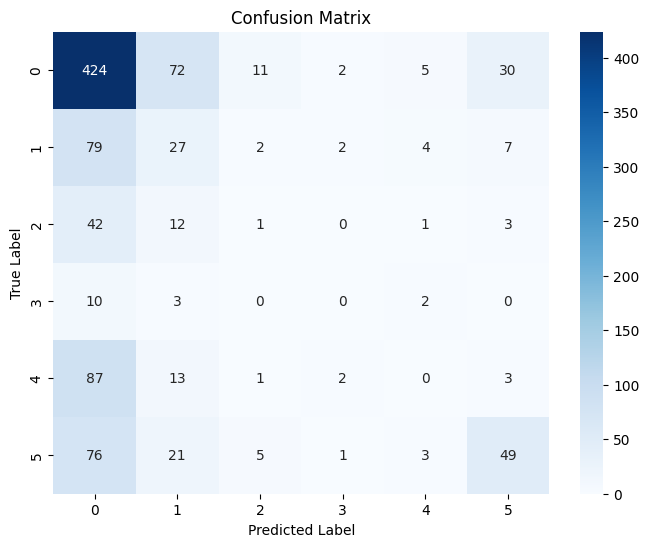

In [ ]:
labels = [str(i) for i in range(cm.shape[0])]  # or use your class names

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


## Per-Class Metrics

Print precision, recall, F1-score, and support for each class.

In [ ]:
# Get precision, recall, F1-score for each class
precision, recall, f1, support = precision_recall_fscore_support(
    true_labels,
    pred_labels,
    average=None  # per-class metrics
)

# Print them
num_classes = len(precision)
for i in range(num_classes):
    print(f"Class {i}:")
    print(f"  Precision: {precision[i]:.4f}")
    print(f"  Recall:    {recall[i]:.4f}")
    print(f"  F1-score:  {f1[i]:.4f}")
    print(f"  Support:   {support[i]}")


Class 0:
  Precision: 0.5905
  Recall:    0.7794
  F1-score:  0.6719
  Support:   544
Class 1:
  Precision: 0.1824
  Recall:    0.2231
  F1-score:  0.2007
  Support:   121
Class 2:
  Precision: 0.0500
  Recall:    0.0169
  F1-score:  0.0253
  Support:   59
Class 3:
  Precision: 0.0000
  Recall:    0.0000
  F1-score:  0.0000
  Support:   15
Class 4:
  Precision: 0.0000
  Recall:    0.0000
  F1-score:  0.0000
  Support:   106
Class 5:
  Precision: 0.5326
  Recall:    0.3161
  F1-score:  0.3968
  Support:   155
